In [1]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy
# !pip install scikit-image

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import warnings
import ale_py
import shimmy
import joblib
import torch
import os

from gym import wrappers
from skimage.measure import block_reduce

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# Run Constants

In [3]:
resume = False # resume training from previous checkpoint
render = False # render video output?
print_ = False # print each observation
show = False
no_grad = False
corner_correct = True
plot_action_every = 0 # 64

timer_i = 500 # number of iterations without reward before noise is intentionally greater than signal
max_i = 1600

record_actions = False # will be handled as true if plot_action_every 
record_probs = False
record_rewards = True
save_path = 'model.pt'

# Model Instantiation

In [4]:
OBS_SHAPE = (210, 160)
XMIN = 26
XMAX = 196
YMIN = 14
YMAX = 144
SHAPE = (XMAX - XMIN, YMAX - YMIN)
downsample = 'max_pool'
dim = np.prod(SHAPE)
if downsample == 'horizontal':
    dim //= 2
elif downsample == 'max_pool':
    dim //= 4

action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
ACTIONS = [0,1,2,3,4,5] # modify to limit available actions
N_CLASSES = len(ACTIONS)

def preprocess(obs, downsample='max_pool', xmin=26, xmax=196, ymin=10, ymax=144):
    assert obs.shape == (210, 160)
    I = obs[xmin:xmax,ymin:ymax] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    if downsample == 'horizontal':
        I = I[::2,:]
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else to 1
    if downsample == 'max_pool':
        # ideally downsampling would be done before changing values in place, but this way the background is ignored easily
        I = block_reduce(I, (2, 2), np.amax)
#     return I.astype(np.float32).ravel() # ravel flattens an array and collapses it into a column vector
    obs = torch.from_numpy(I.ravel()).double().unsqueeze(dim=0)
    return obs

In [5]:
def show_obs(obs):
    """ 
    Simple display of image observation 
    
    Args:
    `obs` : np.ndarray
    - Observation from the environment
    """
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

def plot_action_counts(action_list):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    transform = lambda x : action_dict[int(x)]
    action_series = pd.Series(action_list, name='Count').dropna()
    data = action_series.value_counts().sort_index()
    data /= data.sum() # normalize to probabilities
    data.index = list(map(transform, data.index))
    data = data.to_frame().transpose()
    sns.barplot(data=data, palette='Spectral', ax=ax)
    plt.show()
    return

In [6]:
def add_noise(probs, i, i_since_r, timer_i, buffer=None, print_=False):        
    # autograd no inplace ops
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    sigma = 2 / n
    noise = torch.normal(0., sigma, (1, n)) # means, stds shared, size n
    noise = noise - noise.mean()
    
    scale = i_since_r / (timer_i - buffer)

    probs = probs + noise * scale
    pmin = torch.min(probs)
    if pmin < 0:
        probs = probs - pmin
        probs = probs / torch.sum(probs)
        
    return probs

def balance_lr(probs, i_since_r, timer_i, beta=1, buffer=None):
#     2 : 'RIGHT'
#     3 : 'LEFT'
#     4 : 'RIGHTFIRE'
#     5 : 'LEFTFIRE'
    if i_since_r < timer_i / 4:
        return probs
    elif i_since_r < timer_i / 2:
        alpha = .5
    elif i_since_r < timer_i * 3 / 4:
        alpha = .8
    else:
        alpha = .99

    zero_probs = torch.zeros_like(probs)
    zero_probs[0,2] = (probs[0,3] - probs[0,2]) / 2
    zero_probs[0,3] = (probs[0,2] - probs[0,3]) / 2
    
    zero_probs[0,4] = (probs[0,5] - probs[0,4]) / 2
    zero_probs[0,5] = (probs[0,4] - probs[0,5]) / 2
    zero_probs = zero_probs * alpha * beta / 2
    
    probs = probs + zero_probs
    with torch.no_grad():
        assert torch.sum(probs).round(decimals=3) == 1, torch.sum(probs)
    return probs
    
def modify_reward(action, reward, info, prev_lives):
    if info['lives'] < prev_lives:
        reward -= 15
    if reward <= 0 and action in [1,4,5]:
        reward -= 1
    return reward

In [7]:
def process_probs(probs, i, last_i, max_i=5_000, timer_i=1000, corner_correct=True, print_=False):
    initial_shape = probs.shape
    i_since_r = i - last_i
    truncated = if i_since_r > timer_i or i_since_r > max_i
    if truncated and print_:
        print('Timer causing reset')
        
    if corner_correct: # heavily biases agent from getting 'stuck' in corner
        probs = add_noise(probs, i, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)

    if torch.round(torch.sum(probs), decimals=4) != 1:
        warnings.warn(str(probs) + ' | ' + str(torch.sum(probs)) + ' != 1')
        probs = probs / torch.sum(probs)
        
    assert probs.shape == initial_shape
    return probs, truncated

def standardize(returns):
    eps = np.finfo(np.float64).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)
    return returns

In [8]:
class TwoLayerReinforcement(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gamma=.99, lr=.01):
        super(TwoLayerReinforcement, self).__init__()
        self.gamma = gamma
        
        self.log_probss = list()
        self.rewards = list()
#         self.episode_rewards = list()
        self.episode_losses = list()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=lr)
        return
        
    def forward(self, x):
        assert len(x.shape) == 2
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        probs = self.softmax(x)
        return probs

    def discount_rewards(self):
        running_add = 0
        discounted_rewards = list()
        for reward in self.rewards:
            running_add = running_add * self.gamma + reward
            discounted_rewards.append(running_add)
        discounted_rewards = torch.tensor(list(reversed(discounted_rewards)))
        return discounted_rewards

    def reward_loss(self):
        assert len(self.rewards)

        discounted_rewards = self.discount_rewards()
        discounted_rewards = standardize(discounted_rewards)
        log_probs = -torch.cat(self.log_probss)
        
        loss = torch.sum(torch.mul(log_probs, discounted_rewards))
        return loss
    
    def episode_backward(self):
        assert len(self.log_probss)
        episode_loss = self.reward_loss()
        self.episode_losses.append(episode_loss.unsqueeze(0))
        
        model.log_probss.clear()
        model.rewards.clear()
        return model
    
    def batch_backward(self):
        assert len(self.episode_losses)
        self.optimizer.zero_grad() # make sure this shouldn't go in reward_loss
        loss = torch.sum(torch.cat(self.episode_losses))
        loss.backward()
        self.optimizer.step()
        self.episode_losses.clear()
        return model
    
    def clear(self):
        self.log_probss.clear()
        self.rewards.clear()
        return
    
    def save(self, save_path=f'{linear_layer.out_features}n_model.pt'):
        torch.save(self, save_path)

In [9]:
model = TwoLayerReinforcement(dim, 64, 6).double() 
if resume:
    model.load_state_dict(torch.load(save_path))
    model.eval()

In [10]:
n_episodes = 2560
batch_size = 256

prev_x = None # used in computing the difference frame
reward_sum = 0
adj_reward_sum = 0
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', # alternate games can be chosen here 
    obs_type='grayscale', # saves RGB preprocessing reduction
    render_mode='human' if render else None, # rendering shows popup but limits training speed
)

if record_actions:
    action_list = list()
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()

episode_number = 0
prev_lives = 0
i = 0

obs, info = env.reset()
while episode_number <= n_episodes:
    curr_x = preprocess(obs, downsample=downsample, xmin=XMIN, xmax=XMAX, ymin=YMIN, ymax=YMAX)
    x = curr_x - prev_x if prev_x is not None else torch.zeros((1, dim)).double() # only monitor change between frames
    prev_x = curr_x
    assert x.dim() == 2, x.dim()
    model_probs = model(x) # autograd performed here
    probs, ptruncated = process_probs(model_probs, i, last_i, max_i=max_i, timer_i=timer_i, corner_correct=corner_correct)

    if record_probs:
        prob_list.append(probs)

    m = torch.distributions.Categorical(probs)
    action = m.sample() 

    log_probs = m.log_prob(action)
    model.log_probss.append(log_probs)
    action = action.item()

    if record_actions or plot_action_every:
        action_list.append(action)
    ######################################################################################
    # fold this into model
    # fix log probs here
    # https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py
    # log_prob = prob.clamp(min=1e-6).log()
    # entropy = - (probs * probs.clamp(min=1e-6).log()).sum()
    # https://discuss.pytorch.org/t/policy-gradient-using-loss-as-reward/13877
    ######################################################################################

    prev_lives = info['lives'] # lives not available through general step return
    obs, reward, terminated, truncated, info = env.step(action) # step returns all other relevant information 
#     terminated = terminated or pterminated
    truncated = truncated or ptruncated
    
    if reward > 0: # reset the iterations since last reward if reward is accrued
        last_i = i

    reward_sum += reward # total round reward incremented
    adj_reward = modify_reward(action, reward, info, prev_lives) # adjusted reward may better lead agent toward short term optimums
    adj_reward_sum += adj_reward

    model.rewards.append(adj_reward)
    ######################################################

    if terminated: # an episode finished
        print(f'\nEpisode {episode_number} of {n_episodes}                \n\n', end='\r')
        
        episode_number += 1

        # Finish The Episode
        model.episode_backward()
        
        # Finish the Batch
        if not no_grad and not episode_number % batch_size:
            model.batch_backward()
            model.save()
            
        if plot_action_every and not episode_number % plot_action_every:
            plot_action_counts(action_list)
            action_list.clear()
        
        if record_rewards:
            reward_list.append(reward_sum)

        reward_sum = 0 # reset all totals
        adj_reward_sum = 0
        
        obs, info = env.reset() # reset env
        prev_x = None
        i = 0
    elif truncated: # an episode terminated unexpectedly, shouldn't maintain results
        model.episode_losses.clear()
        model.log_probss.clear()
        model.rewards.clear()
        
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
        i = 0
    else:
        print(i, end='                          \r')
    i += 1

env.close()

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


626                          
Episode 0 of 2560                

765                          
Episode 1 of 2560                

745                          
Episode 2 of 2560                

224                          
Episode 3 of 2560                

1590                          
Episode 4 of 2560                

303                          
Episode 5 of 2560                

923                          
Episode 6 of 2560                

544                          
Episode 7 of 2560                

188                          
Episode 8 of 2560                

772                          
Episode 9 of 2560                

1266                          
Timer causing reset               

434                          
Episode 10 of 2560                

710                          
Episode 11 of 2560                

1360                          
Episode 12 of 2560                

348                          
Episode 13 of 2560                

1482             

722                          
Episode 112 of 2560                

1453                          
Episode 113 of 2560                

1282                          
Episode 114 of 2560                

582                          
Episode 115 of 2560                

1297                          
Episode 116 of 2560                

847                          
Episode 117 of 2560                

869                          
Episode 118 of 2560                

682                          
Episode 119 of 2560                

1664                          
Episode 120 of 2560                

741                          
Episode 121 of 2560                

763                          
Episode 122 of 2560                

795                          
Timer causing reset               

1050                          
Episode 123 of 2560                

1248                          
Episode 124 of 2560                

836                          
Episode 125 of 2560        

1168                          
Episode 227 of 2560                

934                          
Episode 228 of 2560                

566                          
Episode 229 of 2560                

1281                          
Episode 230 of 2560                

539                          
Episode 231 of 2560                

1153                          
Timer causing reset               

739                          
Episode 232 of 2560                

873                          
Episode 233 of 2560                

875                          
Episode 234 of 2560                

1345                          
Episode 235 of 2560                

840                          
Episode 236 of 2560                

1282                          
Timer causing reset               

710                          
Episode 237 of 2560                

480                          
Episode 238 of 2560                

1772                          
Episode 239 of 2560         

242                          
Episode 289 of 2560                

899                          
Timer causing reset               

310                          
Episode 290 of 2560                

1022                          
Episode 291 of 2560                

844                          
Timer causing reset               

1530                          
Timer causing reset               

790                          
Timer causing reset               

895                          
Timer causing reset               

1493                          
Timer causing reset               

304                          
Episode 292 of 2560                

531                          
Episode 293 of 2560                

1820                          
Timer causing reset               

1021                          
Timer causing reset               

1062                          
Timer causing reset               

164                          
Episode 294 of 2560                

874                          
Timer causing reset               

916                          
Timer causing reset               

1242                          
Episode 344 of 2560                

1749                          
Episode 345 of 2560                

1540                          
Timer causing reset               

996                          
Episode 346 of 2560                

971                          
Timer causing reset               

943                          
Timer causing reset               

843                          
Timer causing reset               

838                          
Timer causing reset               

783                          
Timer causing reset               

867                          
Episode 347 of 2560                

224                          
Episode 348 of 2560                

833                          
Timer causing reset               

677                          
Episode 349 of 2560                

1

455                          
Episode 398 of 2560                

391                          
Episode 399 of 2560                

1066                          
Episode 400 of 2560                

819                          
Episode 401 of 2560                

705                          
Timer causing reset               

1029                          
Timer causing reset               

914                          
Timer causing reset               

1177                          
Episode 402 of 2560                

910                          
Timer causing reset               

532                          
Episode 403 of 2560                

708                          
Episode 404 of 2560                

802                          
Timer causing reset               

1327                          
Timer causing reset               

241                          
Episode 405 of 2560                

1187                          
Timer causing reset              

873                          
Timer causing reset               

1463                          
Timer causing reset               

626                          
Episode 451 of 2560                

1226                          
Episode 452 of 2560                

766                          
Timer causing reset               

792                          
Timer causing reset               

353                          
Episode 453 of 2560                

939                          
Episode 454 of 2560                

994                          
Timer causing reset               

1163                          
Timer causing reset               

1207                          
Timer causing reset               

806                          
Timer causing reset               

563                          
Episode 455 of 2560                

869                          
Timer causing reset               

251                          
Episode 456 of 2560                



837                          
Timer causing reset               

986                          
Timer causing reset               

1038                          
Timer causing reset               

876                          
Timer causing reset               

1300                          
Timer causing reset               

647                          
Episode 501 of 2560                

391                          
Episode 502 of 2560                

753                          
Timer causing reset               

1063                          
Timer causing reset               

921                          
Episode 503 of 2560                

423                          
Episode 504 of 2560                

584                          
Episode 505 of 2560                

326                          
Episode 506 of 2560                

1083                          
Episode 507 of 2560                

1193                          
Timer causing reset               

775                          
Timer causing reset               

901                          
Timer causing reset               

1010                          
Timer causing reset               

1045                          
Episode 544 of 2560                

1762                          
Timer causing reset               

923                          
Timer causing reset               

1338                          
Timer causing reset               

833                          
Timer causing reset               

1029                          
Timer causing reset               

1057                          
Timer causing reset               

2117                          
Timer causing reset               

850                          
Timer causing reset               

1124                          
Timer causing reset               

1146                          
Timer causing reset               

1280                          
Timer causing reset               


1808                          
Episode 577 of 2560                

1563                          
Timer causing reset               

869                          
Timer causing reset               

956                          
Episode 578 of 2560                

1558                          
Episode 579 of 2560                

1671                          
Timer causing reset               

176                          
Episode 580 of 2560                

913                          
Timer causing reset               

1392                          
Timer causing reset               

875                          
Timer causing reset               

729                          
Timer causing reset               

1471                          
Timer causing reset               

1459                          
Episode 581 of 2560                

973                          
Timer causing reset               

707                          
Episode 582 of 2560               

907                          
Timer causing reset               

1231                          
Episode 616 of 2560                

758                          
Timer causing reset               

850                          
Episode 617 of 2560                

750                          
Timer causing reset               

924                          
Timer causing reset               

494                          
Episode 618 of 2560                

874                          
Timer causing reset               

894                          
Episode 619 of 2560                

783                          
Timer causing reset               

974                          
Timer causing reset               

727                          
Timer causing reset               

854                          
Timer causing reset               

1256                          
Timer causing reset               

1479                          
Timer causing reset               

133

477                          
Episode 661 of 2560                

1445                          
Timer causing reset               

1400                          
Timer causing reset               

1770                          
Timer causing reset               

1366                          
Timer causing reset               

482                          
Episode 662 of 2560                

891                          
Timer causing reset               

748                          
Timer causing reset               

896                          
Timer causing reset               

1283                          
Timer causing reset               

771                          
Timer causing reset               

592                          
Episode 663 of 2560                

1508                          
Episode 664 of 2560                

1262                          
Episode 665 of 2560                

195                          
Episode 666 of 2560               

890                          
Timer causing reset               

1092                          
Timer causing reset               

971                          
Timer causing reset               

480                          
Episode 704 of 2560                

1020                          
Timer causing reset               

1488                          
Episode 705 of 2560                

959                          
Timer causing reset               

1001                          
Timer causing reset               

1052                          
Timer causing reset               

1276                          
Timer causing reset               

267                          
Episode 706 of 2560                

1606                          
Timer causing reset               

1325                          
Episode 707 of 2560                

829                          
Timer causing reset               

613                          
Episode 708 of 2560               

792                          
Timer causing reset               

494                          
Episode 753 of 2560                

1162                          
Timer causing reset               

1313                          
Episode 754 of 2560                

1165                          
Timer causing reset               

564                          
Episode 755 of 2560                

1041                          
Episode 756 of 2560                

2214                          
Episode 757 of 2560                

969                          
Timer causing reset               

933                          
Timer causing reset               

785                          
Episode 758 of 2560                

778                          
Timer causing reset               

1226                          
Timer causing reset               

865                          
Timer causing reset               

1434                          
Timer causing reset              

783                          
Timer causing reset               

259                          
Episode 790 of 2560                

1360                          
Episode 791 of 2560                

1542                          
Timer causing reset               

1326                          
Timer causing reset               

900                          
Timer causing reset               

831                          
Timer causing reset               

754                          
Timer causing reset               

1661                          
Timer causing reset               

895                          
Timer causing reset               

850                          
Timer causing reset               

1355                          
Timer causing reset               

321                          
Episode 792 of 2560                

815                          
Episode 793 of 2560                

923                          
Timer causing reset               

8

1025                          
Timer causing reset               

1225                          
Timer causing reset               

1283                          
Timer causing reset               

723                          
Timer causing reset               

1720                          
Timer causing reset               

753                          
Timer causing reset               

386                          
Episode 823 of 2560                

307                          
Episode 824 of 2560                

1151                          
Timer causing reset               

303                          
Episode 825 of 2560                

892                          
Timer causing reset               

1200                          
Timer causing reset               

1405                          
Timer causing reset               

1442                          
Timer causing reset               

973                          
Episode 826 of 2560                

1067                          
Timer causing reset               

672                          
Episode 849 of 2560                

878                          
Timer causing reset               

714                          
Timer causing reset               

784                          
Timer causing reset               

716                          
Timer causing reset               

847                          
Timer causing reset               

764                          
Timer causing reset               

702                          
Episode 850 of 2560                

193                          
Episode 851 of 2560                

804                          
Episode 852 of 2560                

960                          
Timer causing reset               

974                          
Timer causing reset               

960                          
Timer causing reset               

1123                          
Timer causing reset               

2038

1008                          
Episode 872 of 2560                

1016                          
Timer causing reset               

697                          
Timer causing reset               

1142                          
Timer causing reset               

1248                          
Timer causing reset               

895                          
Timer causing reset               

1441                          
Timer causing reset               

1155                          
Timer causing reset               

1065                          
Timer causing reset               

1515                          
Timer causing reset               

766                          
Timer causing reset               

791                          
Timer causing reset               

1224                          
Timer causing reset               

705                          
Timer causing reset               

1479                          
Timer causing reset               


1085                          
Timer causing reset               

825                          
Timer causing reset               

916                          
Timer causing reset               

987                          
Timer causing reset               

811                          
Timer causing reset               

884                          
Timer causing reset               

895                          
Timer causing reset               

1026                          
Timer causing reset               

968                          
Timer causing reset               

849                          
Timer causing reset               

820                          
Timer causing reset               

774                          
Episode 901 of 2560                

901                          
Timer causing reset               

946                          
Timer causing reset               

645                          
Episode 902 of 2560                

851   

773                          
Timer causing reset               

931                          
Timer causing reset               

381                          
Episode 930 of 2560                

793                          
Timer causing reset               

801                          
Timer causing reset               

1053                          
Timer causing reset               

826                          
Timer causing reset               

846                          
Timer causing reset               

1176                          
Timer causing reset               

744                          
Timer causing reset               

931                          
Timer causing reset               

854                          
Timer causing reset               

1151                          
Timer causing reset               

1026                          
Timer causing reset               

1064                          
Timer causing reset               

779 

795                          
Timer causing reset               

807                          
Timer causing reset               

1068                          
Timer causing reset               

255                          
Episode 956 of 2560                

997                          
Timer causing reset               

1053                          
Timer causing reset               

748                          
Timer causing reset               

1292                          
Timer causing reset               

1104                          
Episode 957 of 2560                

1756                          
Timer causing reset               

1059                          
Episode 958 of 2560                

718                          
Timer causing reset               

1404                          
Timer causing reset               

2020                          
Timer causing reset               

1541                          
Timer causing reset               

1051                          
Timer causing reset               

1518                          
Episode 986 of 2560                

613                          
Episode 987 of 2560                

1220                          
Timer causing reset               

1347                          
Timer causing reset               

1394                          
Timer causing reset               

897                          
Timer causing reset               

1634                          
Episode 988 of 2560                

924                          
Timer causing reset               

1092                          
Timer causing reset               

1070                          
Timer causing reset               

743                          
Timer causing reset               

755                          
Timer causing reset               

835                          
Timer causing reset               

1439                          
Timer causing reset               

1265                          
Episode 1006 of 2560                

932                          
Timer causing reset               

241                          
Episode 1007 of 2560                

801                          
Timer causing reset               

861                          
Timer causing reset               

887                          
Timer causing reset               

757                          
Timer causing reset               

1283                          
Timer causing reset               

873                          
Timer causing reset               

801                          
Timer causing reset               

1553                          
Episode 1008 of 2560                

854                          
Timer causing reset               

777                          
Timer causing reset               

1442                          
Timer causing reset               

989                          
Episode 1009 of 2560                

1768                          
Timer causing reset               

974                          
Timer causing reset               

1910                          
Timer causing reset               

1551                          
Episode 1035 of 2560                

1225                          
Timer causing reset               

481                          
Episode 1036 of 2560                

1247                          
Timer causing reset               

709                          
Episode 1037 of 2560                

886                          
Timer causing reset               

1514                          
Timer causing reset               

627                          
Episode 1038 of 2560                

875                          
Timer causing reset               

844                          
Episode 1039 of 2560                

1233                          
Episode 1040 of 2560                

888                          
Timer causing reset        

779                          
Timer causing reset               

999                          
Episode 1071 of 2560                

882                          
Timer causing reset               

2325                          
Timer causing reset               

811                          
Timer causing reset               

1015                          
Timer causing reset               

1129                          
Episode 1072 of 2560                

485                          
Episode 1073 of 2560                

1404                          
Timer causing reset               

871                          
Timer causing reset               

597                          
Episode 1074 of 2560                

735                          
Timer causing reset               

1630                          
Timer causing reset               

640                          
Episode 1075 of 2560                

937                          
Timer causing reset            

861                          
Timer causing reset               

1833                          
Episode 1100 of 2560                

756                          
Timer causing reset               

891                          
Timer causing reset               

810                          
Timer causing reset               

769                          
Episode 1101 of 2560                

879                          
Timer causing reset               

1105                          
Timer causing reset               

1008                          
Timer causing reset               

842                          
Timer causing reset               

675                          
Episode 1102 of 2560                

581                          
Episode 1103 of 2560                

748                          
Timer causing reset               

855                          
Timer causing reset               

1174                          
Timer causing reset               

675                          
Episode 1133 of 2560                

1033                          
Timer causing reset               

681                          
Episode 1134 of 2560                

442                          
Episode 1135 of 2560                

1479                          
Timer causing reset               

823                          
Episode 1136 of 2560                

290                          
Episode 1137 of 2560                

1685                          
Timer causing reset               

1105                          
Timer causing reset               

1577                          
Timer causing reset               

1576                          
Timer causing reset               

663                          
Episode 1138 of 2560                

921                          
Timer causing reset               

495                          
Episode 1139 of 2560                

1588                          
Timer causing reset      

900                          
Timer causing reset               

367                          
Episode 1175 of 2560                

1185                          
Timer causing reset               

1531                          
Timer causing reset               

348                          
Episode 1176 of 2560                

1324                          
Timer causing reset               

890                          
Timer causing reset               

1266                          
Timer causing reset               

1087                          
Timer causing reset               

712                          
Timer causing reset               

1338                          
Timer causing reset               

677                          
Episode 1177 of 2560                

845                          
Timer causing reset               

2144                          
Timer causing reset               

660                          
Episode 1178 of 2560             

971                          
Timer causing reset               

1188                          
Timer causing reset               

529                          
Episode 1211 of 2560                

356                          
Episode 1212 of 2560                

930                          
Timer causing reset               

906                          
Timer causing reset               

888                          
Timer causing reset               

1323                          
Timer causing reset               

299                          
Episode 1213 of 2560                

1687                          
Timer causing reset               

2179                          
Episode 1214 of 2560                

904                          
Timer causing reset               

1727                          
Episode 1215 of 2560                

1844                          
Timer causing reset               

1304                          
Timer causing reset          

962                          
Timer causing reset               

1327                          
Episode 1243 of 2560                

814                          
Timer causing reset               

499                          
Episode 1244 of 2560                

459                          
Episode 1245 of 2560                

583                          
Episode 1246 of 2560                

1921                          
Timer causing reset               

1493                          
Timer causing reset               

886                          
Timer causing reset               

1320                          
Timer causing reset               

1697                          
Timer causing reset               

1562                          
Timer causing reset               

857                          
Timer causing reset               

783                          
Timer causing reset               

1584                          
Timer causing reset            

507                          
Episode 1286 of 2560                

1293                          
Episode 1287 of 2560                

694                          
Episode 1288 of 2560                

1388                          
Timer causing reset               

699                          
Episode 1289 of 2560                

1337                          
Episode 1290 of 2560                

1603                          
Timer causing reset               

1719                          
Episode 1291 of 2560                

897                          
Timer causing reset               

1176                          
Episode 1292 of 2560                

382                          
Episode 1293 of 2560                

370                          
Episode 1294 of 2560                

899                          
Timer causing reset               

1534                          
Timer causing reset               

1116                          
Episode 1295 of 2560

1683                          
Episode 1375 of 2560                

1185                          
Episode 1376 of 2560                

1351                          
Timer causing reset               

1029                          
Episode 1377 of 2560                

1279                          
Timer causing reset               

1153                          
Episode 1378 of 2560                

2480                          
Episode 1379 of 2560                

883                          
Timer causing reset               

582                          
Episode 1380 of 2560                

772                          
Episode 1381 of 2560                

1013                          
Timer causing reset               

916                          
Timer causing reset               

733                          
Episode 1382 of 2560                

809                          
Episode 1383 of 2560                

832                          
Episode 1384 of 2560

1417                          
Timer causing reset               

468                          
Episode 1467 of 2560                

723                          
Episode 1468 of 2560                

1022                          
Timer causing reset               

1005                          
Episode 1469 of 2560                

882                          
Episode 1470 of 2560                

212                          
Episode 1471 of 2560                

826                          
Episode 1472 of 2560                

1159                          
Timer causing reset               

841                          
Timer causing reset               

1031                          
Episode 1473 of 2560                

848                          
Episode 1474 of 2560                

929                          
Episode 1475 of 2560                

828                          
Timer causing reset               

735                          
Episode 1476 of 2560   

942                          
Timer causing reset               

1281                          
Timer causing reset               

1021                          
Timer causing reset               

794                          
Timer causing reset               

469                          
Episode 1543 of 2560                

1057                          
Timer causing reset               

870                          
Timer causing reset               

435                          
Episode 1544 of 2560                

1642                          
Timer causing reset               

789                          
Episode 1545 of 2560                

1067                          
Timer causing reset               

963                          
Timer causing reset               

441                          
Episode 1546 of 2560                

1182                          
Timer causing reset               

1279                          
Episode 1547 of 2560           

806                          
Timer causing reset               

1539                          
Timer causing reset               

888                          
Timer causing reset               

742                          
Timer causing reset               

357                          
Episode 1577 of 2560                

911                          
Timer causing reset               

1266                          
Timer causing reset               

1181                          
Episode 1578 of 2560                

571                          
Episode 1579 of 2560                

1214                          
Timer causing reset               

226                          
Episode 1580 of 2560                

916                          
Timer causing reset               

865                          
Timer causing reset               

1135                          
Timer causing reset               

1006                          
Timer causing reset             

1462                          
Timer causing reset               

1063                          
Timer causing reset               

897                          
Episode 1613 of 2560                

1268                          
Timer causing reset               

877                          
Timer causing reset               

1278                          
Timer causing reset               

837                          
Timer causing reset               

741                          
Timer causing reset               

799                          
Episode 1614 of 2560                

1195                          
Timer causing reset               

1130                          
Timer causing reset               

385                          
Episode 1615 of 2560                

434                          
Episode 1616 of 2560                

1350                          
Timer causing reset               

1343                          
Episode 1617 of 2560          

1181                          
Timer causing reset               

389                          
Episode 1657 of 2560                

1091                          
Timer causing reset               

1325                          
Timer causing reset               

942                          
Timer causing reset               

875                          
Timer causing reset               

974                          
Timer causing reset               

704                          
Timer causing reset               

1439                          
Episode 1658 of 2560                

922                          
Timer causing reset               

1789                          
Timer causing reset               

581                          
Episode 1659 of 2560                

1137                          
Timer causing reset               

882                          
Timer causing reset               

693                          
Episode 1660 of 2560              

539                          
Episode 1698 of 2560                

920                          
Timer causing reset               

840                          
Timer causing reset               

195                          
Episode 1699 of 2560                

1038                          
Episode 1700 of 2560                

1786                          
Timer causing reset               

976                          
Timer causing reset               

995                          
Timer causing reset               

1057                          
Timer causing reset               

890                          
Timer causing reset               

1184                          
Timer causing reset               

928                          
Timer causing reset               

260                          
Episode 1701 of 2560                

829                          
Timer causing reset               

1013                          
Timer causing reset              

1131                          
Timer causing reset               

763                          
Episode 1742 of 2560                

1035                          
Timer causing reset               

1194                          
Timer causing reset               

964                          
Timer causing reset               

1265                          
Episode 1743 of 2560                

1054                          
Timer causing reset               

1560                          
Timer causing reset               

637                          
Episode 1744 of 2560                

938                          
Timer causing reset               

856                          
Timer causing reset               

1028                          
Timer causing reset               

779                          
Timer causing reset               

1020                          
Timer causing reset               

1475                          
Episode 1745 of 2560           

634                          
Episode 1783 of 2560                

576                          
Episode 1784 of 2560                

869                          
Timer causing reset               

900                          
Timer causing reset               

415                          
Episode 1785 of 2560                

571                          
Episode 1786 of 2560                

626                          
Episode 1787 of 2560                

1314                          
Timer causing reset               

996                          
Timer causing reset               

1133                          
Timer causing reset               

481                          
Episode 1788 of 2560                

887                          
Timer causing reset               

1075                          
Timer causing reset               

1822                          
Timer causing reset               

1110                          
Timer causing reset          

1068                          
Timer causing reset               

803                          
Timer causing reset               

1566                          
Timer causing reset               

909                          
Timer causing reset               

1089                          
Episode 1827 of 2560                

1376                          
Timer causing reset               

821                          
Timer causing reset               

921                          
Timer causing reset               

928                          
Timer causing reset               

939                          
Timer causing reset               

793                          
Episode 1828 of 2560                

1057                          
Timer causing reset               

797                          
Episode 1829 of 2560                

1087                          
Timer causing reset               

406                          
Episode 1830 of 2560              

1406                          
Timer causing reset               

814                          
Episode 1865 of 2560                

811                          
Timer causing reset               

410                          
Episode 1866 of 2560                

1694                          
Timer causing reset               

961                          
Timer causing reset               

1280                          
Timer causing reset               

830                          
Timer causing reset               

980                          
Timer causing reset               

691                          
Episode 1867 of 2560                

1873                          
Timer causing reset               

933                          
Timer causing reset               

1248                          
Timer causing reset               

1068                          
Timer causing reset               

851                          
Timer causing reset               

1098                          
Timer causing reset               

1325                          
Timer causing reset               

1507                          
Timer causing reset               

1335                          
Episode 1903 of 2560                

1063                          
Timer causing reset               

1126                          
Timer causing reset               

929                          
Timer causing reset               

1025                          
Timer causing reset               

927                          
Timer causing reset               

700                          
Episode 1904 of 2560                

812                          
Timer causing reset               

966                          
Timer causing reset               

225                          
Episode 1905 of 2560                

1222                          
Timer causing reset               

1186                          
Timer causing reset            

221                          
Episode 1948 of 2560                

425                          
Episode 1949 of 2560                

1339                          
Episode 1950 of 2560                

1176                          
Episode 1951 of 2560                

1193                          
Timer causing reset               

1023                          
Timer causing reset               

1281                          
Timer causing reset               

812                          
Timer causing reset               

1250                          
Timer causing reset               

829                          
Timer causing reset               

961                          
Episode 1952 of 2560                

917                          
Timer causing reset               

766                          
Timer causing reset               

356                          
Episode 1953 of 2560                

580                          
Episode 1954 of 2560        

1511                          
Timer causing reset               

1369                          
Episode 1982 of 2560                

1089                          
Episode 1983 of 2560                

1373                          
Timer causing reset               

1061                          
Episode 1984 of 2560                

1035                          
Timer causing reset               

813                          
Timer causing reset               

913                          
Timer causing reset               

1182                          
Timer causing reset               

1437                          
Timer causing reset               

224                          
Episode 1985 of 2560                

548                          
Episode 1986 of 2560                

956                          
Timer causing reset               

543                          
Episode 1987 of 2560                

914                          
Timer causing reset       

1003                          
Timer causing reset               

1032                          
Timer causing reset               

261                          
Episode 2028 of 2560                

852                          
Timer causing reset               

939                          
Timer causing reset               

858                          
Episode 2029 of 2560                

1102                          
Timer causing reset               

920                          
Timer causing reset               

1382                          
Timer causing reset               

277                          
Episode 2030 of 2560                

1067                          
Timer causing reset               

1024                          
Timer causing reset               

824                          
Timer causing reset               

709                          
Episode 2031 of 2560                

978                          
Timer causing reset             

725                          
Episode 2061 of 2560                

1012                          
Timer causing reset               

1786                          
Timer causing reset               

874                          
Timer causing reset               

329                          
Episode 2062 of 2560                

773                          
Timer causing reset               

1126                          
Timer causing reset               

1496                          
Timer causing reset               

974                          
Episode 2063 of 2560                

913                          
Timer causing reset               

1784                          
Timer causing reset               

927                          
Timer causing reset               

2455                          
Timer causing reset               

1073                          
Timer causing reset               

382                          
Episode 2064 of 2560             

1143                          
Timer causing reset               

2041                          
Timer causing reset               

1119                          
Episode 2094 of 2560                

380                          
Episode 2095 of 2560                

791                          
Timer causing reset               

981                          
Timer causing reset               

1185                          
Timer causing reset               

862                          
Timer causing reset               

1094                          
Timer causing reset               

1130                          
Timer causing reset               

932                          
Timer causing reset               

973                          
Timer causing reset               

965                          
Timer causing reset               

1089                          
Timer causing reset               

781                          
Timer causing reset               


177                          
Episode 2127 of 2560                

743                          
Timer causing reset               

861                          
Timer causing reset               

876                          
Timer causing reset               

976                          
Timer causing reset               

874                          
Timer causing reset               

1008                          
Timer causing reset               

1149                          
Timer causing reset               

1187                          
Timer causing reset               

1071                          
Timer causing reset               

911                          
Timer causing reset               

1386                          
Timer causing reset               

220                          
Episode 2128 of 2560                

1375                          
Timer causing reset               

912                          
Timer causing reset               



1091                          
Timer causing reset               

380                          
Episode 2164 of 2560                

1227                          
Timer causing reset               

408                          
Episode 2165 of 2560                

1055                          
Timer causing reset               

724                          
Timer causing reset               

789                          
Timer causing reset               

767                          
Timer causing reset               

965                          
Timer causing reset               

885                          
Timer causing reset               

953                          
Timer causing reset               

408                          
Episode 2166 of 2560                

232                          
Episode 2167 of 2560                

1332                          
Timer causing reset               

1183                          
Timer causing reset              

968                          
Timer causing reset               

895                          
Timer causing reset               

1119                          
Timer causing reset               

1431                          
Timer causing reset               

885                          
Timer causing reset               

1181                          
Timer causing reset               

1104                          
Timer causing reset               

331                          
Episode 2191 of 2560                

996                          
Timer causing reset               

923                          
Episode 2192 of 2560                

1128                          
Timer causing reset               

1420                          
Timer causing reset               

1021                          
Timer causing reset               

1007                          
Episode 2193 of 2560                

701                          
Episode 2194 of 2560            

444                          
Episode 2233 of 2560                

875                          
Timer causing reset               

432                          
Episode 2234 of 2560                

972                          
Timer causing reset               

848                          
Timer causing reset               

495                          
Episode 2235 of 2560                

941                          
Episode 2236 of 2560                

1007                          
Episode 2237 of 2560                

547                          
Episode 2238 of 2560                

429                          
Episode 2239 of 2560                

1184                          
Timer causing reset               

559                          
Episode 2240 of 2560                

812                          
Timer causing reset               

1052                          
Timer causing reset               

867                          
Timer causing reset        

507                          
Episode 2270 of 2560                

675                          
Episode 2271 of 2560                

431                          
Episode 2272 of 2560                

927                          
Timer causing reset               

875                          
Timer causing reset               

1312                          
Timer causing reset               

1213                          
Timer causing reset               

1579                          
Timer causing reset               

553                          
Episode 2273 of 2560                

1289                          
Timer causing reset               

1937                          
Timer causing reset               

1420                          
Timer causing reset               

1186                          
Timer causing reset               

962                          
Timer causing reset               

1704                          
Timer causing reset           

838                          
Timer causing reset               

790                          
Timer causing reset               

926                          
Timer causing reset               

1003                          
Timer causing reset               

1115                          
Timer causing reset               

816                          
Timer causing reset               

246                          
Episode 2304 of 2560                

866                          
Timer causing reset               

1245                          
Timer causing reset               

1089                          
Timer causing reset               

1693                          
Timer causing reset               

927                          
Timer causing reset               

1067                          
Timer causing reset               

737                          
Episode 2305 of 2560                

1069                          
Timer causing reset               


1270                          
Timer causing reset               

969                          
Timer causing reset               

1155                          
Timer causing reset               

862                          
Timer causing reset               

952                          
Episode 2326 of 2560                

1181                          
Timer causing reset               

1003                          
Timer causing reset               

1280                          
Timer causing reset               

1245                          
Timer causing reset               

1065                          
Timer causing reset               

1057                          
Timer causing reset               

1166                          
Timer causing reset               

1211                          
Timer causing reset               

1170                          
Timer causing reset               

949                          
Timer causing reset              

1276                          
Timer causing reset               

292                          
Episode 2351 of 2560                

1563                          
Timer causing reset               

1310                          
Timer causing reset               

1001                          
Timer causing reset               

870                          
Timer causing reset               

965                          
Episode 2352 of 2560                

2039                          
Timer causing reset               

1685                          
Episode 2353 of 2560                

762                          
Timer causing reset               

1129                          
Timer causing reset               

952                          
Timer causing reset               

705                          
Episode 2354 of 2560                

746                          
Episode 2355 of 2560                

395                          
Episode 2356 of 2560         

553                          
Episode 2376 of 2560                

871                          
Timer causing reset               

519                          
Episode 2377 of 2560                

1513                          
Timer causing reset               

939                          
Timer causing reset               

1506                          
Timer causing reset               

893                          
Timer causing reset               

959                          
Timer causing reset               

575                          
Episode 2378 of 2560                

750                          
Timer causing reset               

424                          
Episode 2379 of 2560                

879                          
Timer causing reset               

1440                          
Timer causing reset               

929                          
Timer causing reset               

1415                          
Timer causing reset               

1064                          
Timer causing reset               

1100                          
Timer causing reset               

604                          
Episode 2403 of 2560                

931                          
Timer causing reset               

889                          
Timer causing reset               

1022                          
Timer causing reset               

1213                          
Timer causing reset               

1429                          
Timer causing reset               

858                          
Timer causing reset               

1058                          
Timer causing reset               

1038                          
Timer causing reset               

733                          
Episode 2404 of 2560                

1130                          
Timer causing reset               

1183                          
Timer causing reset               

1292                          
Timer causing reset             

1533                          
Timer causing reset               

820                          
Timer causing reset               

910                          
Timer causing reset               

1386                          
Timer causing reset               

1195                          
Timer causing reset               

939                          
Timer causing reset               

987                          
Timer causing reset               

489                          
Episode 2421 of 2560                

802                          
Episode 2422 of 2560                

1271                          
Timer causing reset               

1437                          
Timer causing reset               

1196                          
Timer causing reset               

659                          
Timer causing reset               

906                          
Timer causing reset               

156                          
Episode 2423 of 2560                

1438                          
Timer causing reset               

1495                          
Timer causing reset               

830                          
Timer causing reset               

1004                          
Timer causing reset               

1946                          
Timer causing reset               

952                          
Timer causing reset               

1278                          
Timer causing reset               

1255                          
Timer causing reset               

957                          
Timer causing reset               

887                          
Timer causing reset               

933                          
Timer causing reset               

2344                          
Episode 2445 of 2560                

1388                          
Timer causing reset               

793                          
Timer causing reset               

897                          
Timer causing reset               



1153                          
Timer causing reset               

1155                          
Timer causing reset               

1440                          
Timer causing reset               

943                          
Timer causing reset               

803                          
Timer causing reset               

808                          
Timer causing reset               

971                          
Timer causing reset               

956                          
Timer causing reset               

1324                          
Timer causing reset               

562                          
Episode 2470 of 2560                

1183                          
Timer causing reset               

1183                          
Timer causing reset               

1568                          
Timer causing reset               

961                          
Timer causing reset               

1200                          
Timer causing reset               



1127                          
Timer causing reset               

898                          
Timer causing reset               

954                          
Episode 2488 of 2560                

1310                          
Timer causing reset               

968                          
Timer causing reset               

1062                          
Timer causing reset               

1300                          
Timer causing reset               

980                          
Timer causing reset               

762                          
Timer causing reset               

899                          
Timer causing reset               

840                          
Timer causing reset               

173                          
Episode 2489 of 2560                

1070                          
Timer causing reset               

2039                          
Timer causing reset               

921                          
Timer causing reset               



577                          
Episode 2510 of 2560                

685                          
Episode 2511 of 2560                

882                          
Timer causing reset               

1057                          
Timer causing reset               

1321                          
Timer causing reset               

1818                          
Timer causing reset               

968                          
Timer causing reset               

1113                          
Timer causing reset               

1253                          
Timer causing reset               

1073                          
Timer causing reset               

770                          
Timer causing reset               

889                          
Timer causing reset               

1440                          
Timer causing reset               

936                          
Timer causing reset               

1032                          
Timer causing reset               

703                          
Timer causing reset               

1228                          
Timer causing reset               

1256                          
Timer causing reset               

925                          
Timer causing reset               

875                          
Timer causing reset               

1538                          
Timer causing reset               

1223                          
Timer causing reset               

1194                          
Timer causing reset               

1050                          
Timer causing reset               

852                          
Timer causing reset               

2966                          
Timer causing reset               

1192                          
Timer causing reset               

1043                          
Timer causing reset               

1086                          
Timer causing reset               

1029                          
Episode 2536 of 2560               

351                          
Episode 2560 of 2560                



In [11]:
def plot_probs(prob_list, step=1):
    probs_arr = torch.vstack(prob_list).detach().numpy()
    display(probs_arr.shape)
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=200, sharex=True, sharey=True)
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

if record_probs:
    plot_probs(prob_list)

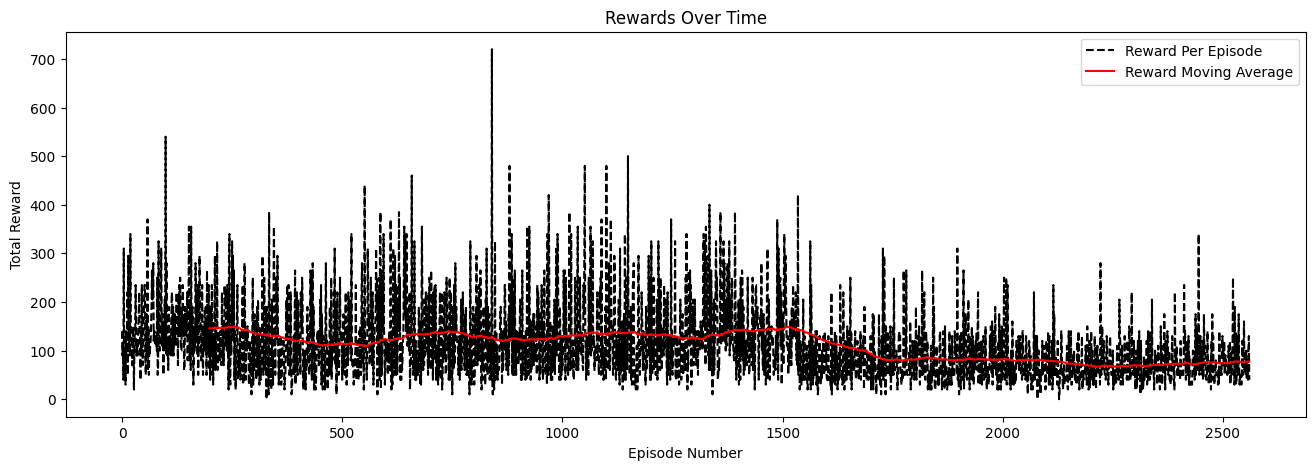

In [12]:
def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.plot(x, reward_list, color='black', linestyle='dashed', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

if record_rewards:
    plot_rewards(reward_list, window_size=200)